Brusselator Model on a Rectangular Mesh!

Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.
/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


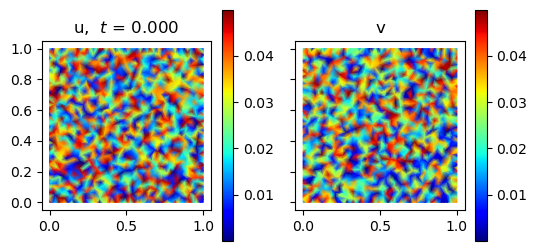

In [5]:
import skfem
import numpy as np
from skfem import MeshTri
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.spatial import distance
from scipy.sparse.linalg import splu 
from skfem.models.poisson import laplace, mass
from skfem.visuals.matplotlib import plot
from scipy.sparse import csc_matrix

def generate_boundary_points(num_points_per_side):
    points = []
    for i in range(num_points_per_side):
        t = i / (num_points_per_side - 1)
        points.append([t, 0])
        points.append([t, 1])
        points.append([0, t])
        points.append([1, t])
    return np.array(points)

def generate_interior_points(num_points, minimum_distance, boundary_points):
    points = boundary_points.tolist()
    while len(points) < num_points:
        point = np.random.rand(2)
        if all(distance.euclidean(point, p) >= minimum_distance for p in points):
            points.append(point)
    return np.array(points)


num_boundary_points_per_side = 50  
num_points = 1200
minimum_distance = 0.0225

boundary_points = generate_boundary_points(num_boundary_points_per_side)

points = generate_interior_points(num_points, minimum_distance, boundary_points)

tri = Delaunay(points)

mesh = MeshTri(points.T, tri.simplices.T)

'''plt.triplot(points[:, 0], points[:, 1], tri.simplices, color='blue')
plt.scatter(points[:, 0], points[:, 1], color='red', s=1.75)
plt.gca().set_aspect(1.0)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.title('Delaunay Triangulation')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()'''


element = skfem.ElementTriP1()  # or ElementTriP2?  a triangular element
basis = skfem.Basis(mesh, element)

D_u  = 1.e-3  #diffusion coefficients 
D_v = D_u*11
dt = .004    # timestep 

L_1 = D_u * skfem.asm(laplace, basis)   # Laplacian for u field 
L_2 = D_v * skfem.asm(laplace, basis)   # for v field 
M = skfem.asm(mass, basis)  # mass matrix (sizes of triangles) 

#L0, M0 = penalize(L, M, D=basis.get_dofs())  # sets boundary to zero Dirichlet boundary 
#L0=L;  #M0=M;
# ACQ otherwise gives Neumann boundary condition!!!!!! 

theta = 0.5                     # Crank–Nicolson algorithm for a diffusion PDE
A_1 = M + theta * L_1 * dt
B_1 = M - (1 - theta) * L_1 * dt
A_2 = M + theta * L_2 * dt
B_2 = M - (1 - theta) * L_2 * dt

# Convert to CSC format
A_1_csc = csc_matrix(A_1)
A_2_csc = csc_matrix(A_2)

# Regularize matrices
epsilon = 1e-10
A_1_csc += epsilon * np.eye(A_1_csc.shape[0])
A_2_csc += epsilon * np.eye(A_2_csc.shape[0])

# Perform factorization
try:
    backsolve_1 = splu(A_1_csc.T).solve
    backsolve_2 = splu(A_2_csc.T).solve
except RuntimeError as e:
    print("RuntimeError:", e)

#backsolve_1 = splu(A_1.T).solve  # .T as splu prefers CSC which is a sparse matrix format (compressed sparse column)
#backsolve_2 = splu(A_2.T).solve

nnodes = len(basis.doflocs[0])
u_init = np.random.random(nnodes)*0.05
v_init = np.random.random(nnodes)*0.05

def Reaction(u,v,alpha,beta,rdtype):
    if (rdtype == 'FN'):  # FitzHugh Nagumo model
        Ru,Rv=R_FN(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Br'):  # Brusellator model
        Ru,Rv= R_Br(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'GS'):  # Gray-Scott model
        Ru,Rv = R_GS(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Heat'):  # Heat equation 
        n = len(u)
        Ru = np.zeros(n); Rv = np.zeros(n)
        return Ru,Rv
    print('invalid reaction type')

#The FitzHugh-Nagumo Reaction Diffusion Model
# example: Du, Dv, alpha, beta = 1, 10, 0.1, 1, dt=0.01, dx = 1
def R_FN(u,v,alpha,beta): 
    Ru =  u - u**3 - v + alpha 
    Rv = (u - v)*beta
    return Ru,Rv
    
# Brusselator Reaction Diffusion model
# example: Du, Dv, alpha, beta = 2, 22, 5, 9 # dt=0.005, dx=1
# u = alpha, v = beta/alpha is a fixed point of R
def R_Br(u,v,alpha,beta): 
    Ru = alpha - (beta+1)*u + (u**2)*v    
    Rv = beta*u - (u**2)*v
    return Ru,Rv

# The Gray-Scott Reaction Diffusion model
# alpha is feed rate for u and kills v, beta is kill or drain rate for v
# example: Du = 0.2, Dv = Du/2, alpha = 0.037 and beta = 0.06 , dx=1
def R_GS(u,v,alpha,beta): 
    Ru =  -u*(v**2) + alpha*(1-u) 
    Rv =  u*(v**2) -(alpha+ beta)*v
    return Ru,Rv

# display u,v fields 
# calls skfem's plot routine 
def disp(mesh,u,v,basis,t):
    fig,axarr = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)
    ax0 = axarr[0]; ax1 = axarr[1]
    ax0.set_aspect('equal'); ax1.set_aspect('equal')
    ax_j0 = plot(mesh, u[basis.nodal_dofs.flatten()], shading='gouraud', ax = ax0)
    ax_j1 = plot(mesh, v[basis.nodal_dofs.flatten()], shading='gouraud', ax = ax1)
    fig = ax0.get_figure()
    field0 = ax0.get_children()[0]  # vertex-based temperature-colour
    field1 = ax1.get_children()[0]  # vertex-based temperature-colour
    fig.colorbar(field0)
    fig.colorbar(field1)
    title = ax0.set_title(f'u,  $t$ = {t:.3f}')
    title = ax1.set_title(f'v')

# show initial conditions 
t=0
disp(mesh,u_init,v_init,basis,t)

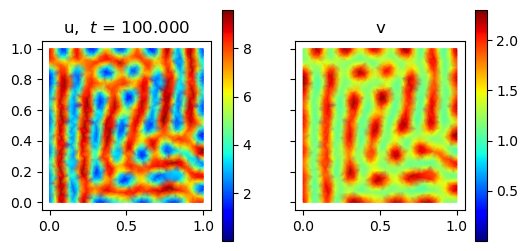

In [7]:
def one_step(t,u,v):
    t += dt
    Ru,Rv = Reaction(u,v,alpha,beta,rdtype)
    u = backsolve_1(B_1 @ u)    
    v = backsolve_2(B_2 @ v)  
    u += Ru*dt
    v += Rv*dt
    return t,u,v

u = u_init; v = v_init; t=0; 
rdtype = 'Br'
alpha = 6.; beta = 9.

for i in range(25000):
    t, u, v = one_step(t,u,v)  
disp(mesh,u,v,basis,t)